In [30]:
import os
import sys
import shutil

baseDir = 'E:/Tuberculosis'
images_path = os.path.join(baseDir, 'Data', 'CXRs')
masks_path = os.path.join(baseDir, 'Data', 'Masks')


print('Number of Xray Images: {}'.format(len(os.listdir(images_path))))
print('Number of Masks: {}'.format(len(os.listdir(masks_path))))

images = os.listdir(images_path)
masks = os.listdir(masks_path)

segmenDir = os.path.join(baseDir, 'Tuberculosis Segmentation')

cxrtrainDir = os.path.join(segmenDir, 'data', 'CXRs', 'Train')
if not os.path.exists(cxrtrainDir):
    os.makedirs(cxrtrainDir)
cxrtestDir = os.path.join(segmenDir, 'data', 'CXRs', 'Test')
if not os.path.exists(cxrtestDir):
    os.makedirs(cxrtestDir)

masktrainDir = os.path.join(segmenDir, 'data', 'Masks', 'Train')
if not os.path.exists(masktrainDir):
    os.makedirs(masktrainDir)
masktestDir = os.path.join(segmenDir, 'data', 'Masks', 'Test')
if not os.path.exists(masktestDir):
    os.makedirs(masktestDir)

for each_mask in masks:
    new_mask_name = each_mask.replace('_mask', "")
    src = os.path.join(masks_path, each_mask)
    dest= os.path.join(masks_path, new_mask_name)
    os.rename(src, dest)
    
print('Preprocessing to match names done for Masks')    




            
    

Number of Xray Images: 800
Number of Masks: 704
Preprocessing to match names done for Masks


In [35]:
images = os.listdir(images_path)
masks = os.listdir(masks_path)

count= 0
for each_img in images:
    count+=1
    if os.path.isfile(os.path.join(masks_path, each_img)):
        cxr_src = os.path.join(images_path, each_img)
        cxr_dest = os.path.join(cxrtrainDir, each_img)
        shutil.copy(cxr_src, cxr_dest)    
        mask_src = os.path.join(masks_path, each_img)
        mask_dest = os.path.join(masktrainDir, each_img)
        shutil.copy(mask_src, mask_dest)    
    else:
        cxr_src = os.path.join(images_path, each_img)
        cxr_dest = os.path.join(cxrtestDir, each_img)
        shutil.copy(cxr_src, cxr_dest)
    sys.stdout.write('\r Operation Counting Images: {}/{}'.format(count, len(images)))
    
    

 Operation Counting Images: 800/800

In [73]:
import numpy as np
from keras.preprocessing.image import load_img

cxrs = os.listdir(cxrtrainDir)
masks = os.listdir(masktrainDir)
print('Training CXRS: {} | Training Masks: {}'.format(len(cxrs), len(masks)))

X=[]
Y=[]
IMG_SIZE=512

count=0
for each_cxr in cxrs:
    count+=1
    cxr = np.asarray(load_img(os.path.join(cxrtrainDir, each_cxr),
                              color_mode='grayscale', target_size=(IMG_SIZE, IMG_SIZE),
                              interpolation='lanczos'))
    cxr = (cxr/255.0).astype('float32')
    
    mask = np.asarray(load_img(os.path.join(masktrainDir, each_cxr),
                              color_mode='grayscale', target_size=(IMG_SIZE, IMG_SIZE),
                              interpolation='lanczos'))
    mask = (mask/255.0).astype('float32')

    X.append(cxr)
    Y.append(mask)
    sys.stdout.write('\r Operation Counting Images: {}/{}'.format(count, len(cxrs)))

X = np.asarray(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = np.asarray(Y).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

Training CXRS: 704 | Training Masks: 704
 Operation Counting Images: 704/704

In [82]:
np.save(os.path.join(cxrtrainDir, 'CXRS'), X)
np.save(os.path.join(masktrainDir, 'Masks'), Y)
print('Images and Masks are saved to Numpy Arrays in respective Directories')

'E:/Tuberculosis\\Tuberculosis Segmentation\\data\\CXRs\\Train'

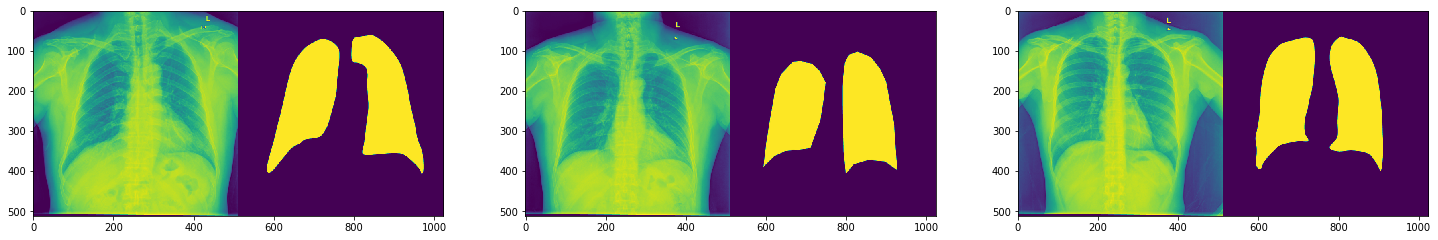

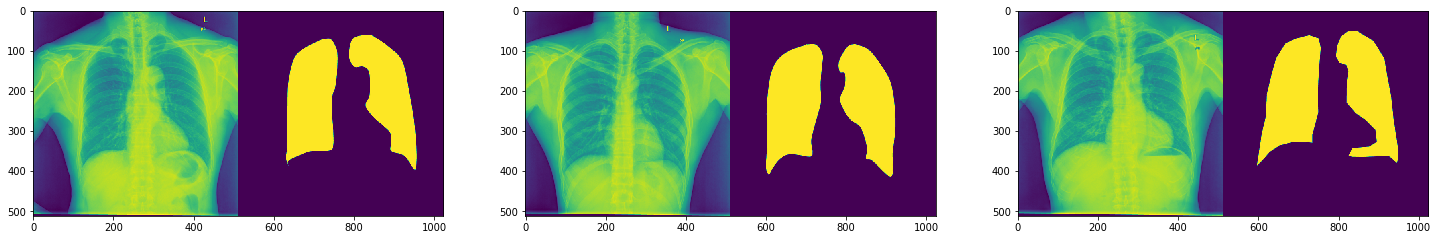

In [83]:
import matplotlib.pyplot as plt

def plotMask(Images, Masks):
    sample = []
    for i in range(6):
        left = Images[i, :, :, 0]
        right = Masks[i, :, :, 0]
        combined = np.hstack((left,right))
        sample.append(combined)
        
    for i in range(0, 6, 3):
        plt.figure(figsize=(25,10))
        
        plt.subplot(2,3,1+i)
        plt.imshow(sample[i])
        
        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1])
        
        
        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2])
        
        plt.show()

plotMask(X, Y)

In [84]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler


def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])


In [85]:
model = unet(input_size=(IMG_SIZE, IMG_SIZE, 1))
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, 
              metrics=[dice_coef, 'binary_accuracy'])
model.summary()






__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 32) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2

In [1]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path=os.path.join(segmenDir, "{}_weights.best.hdf5".format('Lungs Segmentation Model'))

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", mode="min", patience=15) 
callbacks_list = [checkpoint, early, reduceLROnPlat]

loss_history = model.fit(x = X, y = Y, batch_size = 16, epochs = 50,
                         validation_split = 0.10, callbacks=callbacks_list)

Using TensorFlow backend.


NameError: name 'os' is not defined

In [3]:
#Load Already Saved Model and get Results

import os
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import load_img
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

IMG_SIZE = 512

def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10]) 

weight_path = 'E:/Tuberculosis/Tuberculosis Segmentation/Lungs_Segmentation_previous.hdf5'
segmentation_model = unet(input_size=(IMG_SIZE, IMG_SIZE, 1))
segmentation_model.load_weights(weight_path)
segmentation_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 512, 512, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 512, 512, 32) 9248        conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 256, 256, 32) 0           conv2d_21[0][0]                  
__________________________________________________________________________________________________
conv2d_22 

In [12]:
from keras.preprocessing.image import load_img, img_to_array, save_img
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm_notebook as tqdm

dataDir = '../Tuberculosis Segmentation/data'
fullcxrDir = os.path.join(dataDir, 'CXRs', 'FullCXRs')

PredictedMasksDir = os.path.join(dataDir, 'Predicted Masks')
if not os.path.exists(PredictedMasksDir):
    os.makedirs(PredictedMasksDir)

ExtractedLungsDir = os.path.join(dataDir, 'Extracted Lungs')
if not os.path.exists(ExtractedLungsDir):
    os.makedirs(ExtractedLungsDir)

cxrs = os.listdir(fullcxrDir)

for each_cxr in tqdm(cxrs):
    cxr = img_to_array(load_img(os.path.join(fullcxrDir, each_cxr),
                              color_mode='grayscale', target_size=(IMG_SIZE, IMG_SIZE),
                              interpolation='lanczos'))
    cxr = (cxr-127.0)/127.0
    cxr  =cxr.reshape(-1, 512, 512, 1)
    predicted_lung = segmentation_model.predict(cxr)
    save_img(os.path.join(PredictedMasksDir, each_cxr), predicted_lung[0, :, :, :], data_format=None,
                          file_format=None, scale=True)

In [16]:

for each_cxr in tqdm(cxrs):
    cxr = img_to_array(load_img(os.path.join(fullcxrDir, each_cxr),
                              color_mode='grayscale', target_size=(IMG_SIZE, IMG_SIZE),
                              interpolation='lanczos'))
    mask = img_to_array(load_img(os.path.join(PredictedMasksDir, each_cxr), color_mode='grayscale'))
    lung = np.multiply(cxr, mask)
    save_img(os.path.join(ExtractedLungsDir, each_cxr), lung, data_format=None, file_format=None, scale=True)
                     


'../Tuberculosis Segmentation/data\\Extracted Lungs Belarus'